---
## Preliminaries
---

### Import libraries

In [9]:
from copy import deepcopy
import matplotlib.pyplot as plt
import pickle
import torch
from tqdm import tqdm
from torch import nn, optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
plt.rcParams.update({
        'text.usetex' : True,
        'font.family' : 'Times',
        'text.latex.preamble' : r'''
    \usepackage{amsmath}
    \usepackage{amssymb}
    \usepackage{times}
    \usepackage{amsfonts}
''',
        'legend.shadow' : False,
        'legend.framealpha' : 1,
        'legend.fancybox' : True,
        'legend.edgecolor' : 'gray',
    }) 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Utility Functions

In [2]:
# Data utilities

## Dataset loaders (CIFAR10, FashionMNIST, MNIST)
def load_CIFAR10():
    return (
        datasets.CIFAR10(root='data/CIFAR10', transform=transforms.ToTensor(), train=True, download=True),
        datasets.CIFAR10(root='data/CIFAR10', transform=transforms.ToTensor(), train=False, download=True),
    )

def load_Fashion_MNIST():
    return (
        datasets.FashionMNIST(root='data', transform=transforms.ToTensor(), train=True, download=True),
        datasets.FashionMNIST(root='data', transform=transforms.ToTensor(), train=False, download=True),
    )

def load_MNIST():
    return (
        datasets.MNIST(root='data', transform=transforms.ToTensor(), train=True, download=True),
        datasets.MNIST(root='data', transform=transforms.ToTensor(), train=False, download=True),
    )


## Get indices of certain class
def idxs_of_classes(dataset, classes):
    if type(classes) == int:
        classes = (classes,)
    idxs_of_class = lambda c: (torch.as_tensor(dataset.targets) == c).nonzero().squeeze()
    return torch.cat([idxs_of_class(c) for c in classes], dim=0)


## Create subset of dataset
def dataset_split(dataset, idxs):
    return torch.utils.data.Subset(dataset, idxs)


## Sample from a dataset
def sample_dataset(dataset, pct=None, n=None, classes=None):
    # indices of datapoints that should be sampled from (i.e. by class)
    if classes is None:
        idxs = torch.arange(len(dataset))
    else:
        idxs = idxs_of_classes(dataset, classes)

    # determine number of datapoints to sample 
    if n is None and pct is not None:
        n = int(pct * len(idxs))
    else:
        assert n is not None, 'pct or n must be provided'
    
    # sample indices
    idxs = idxs.repeat(n // len(idxs) + 1)
    idxs_shuffled = idxs[torch.randperm(len(idxs))]
    idxs_sampled = idxs_shuffled[:n]

    # return dataset split
    return dataset_split(dataset, idxs_sampled)


## Create dataloader
def dataloader(dataset, batch_size=100):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=0, shuffle=True)


## Vectorize model
def vectorize_model(model):
    parameters = [p.data for p in model.parameters()]
    return torch.nn.utils.parameters_to_vector(parameters)


## Try getting GPU (for moving tensors across devices)
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')


In [3]:
# Define client
class Client():
    def __init__(self, net, trainset, testset, lr=0.01, scheduler_step=13, batch_size=100):
        self.net = deepcopy(net)
        self.trainloader = dataloader(trainset, batch_size)
        self.testloader = dataloader(testset, batch_size)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=scheduler_step, gamma=0.2)

        self.train_loss_tracker = []
        self.train_acc_tracker = []
        self.test_loss_tracker = []
        self.test_acc_tracker = []
    
    def train(self):
        self.net.train()
        correct, total = 0, 0
        for inputs, targets in self.trainloader:
            # calculate loss on batch and backprop
            self.optimizer.zero_grad()
            outputs = self.net(inputs)
            loss = nn.CrossEntropyLoss()(outputs, targets)
            loss.backward()
            self.optimizer.step()

            # track loss and accuracy
            self.train_loss_tracker.append(loss.item())
            _, pred = outputs.max(1)
            total += len(targets)
            correct += (pred == targets).sum().item()
        acc = correct / total
        self.train_acc_tracker.append(acc)

    def test(self):
        self.net.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, targets in self.testloader:
                # calculate loss on batch
                outputs = self.net(inputs)
                loss = nn.CrossEntropyLoss()(outputs, targets)

                # track loss and accuracy
                self.test_loss_tracker.append(loss.item())
                _, pred = outputs.max(1)
                total += len(targets)
                correct += (pred == targets).sum().item()
        acc = correct / total
        self.test_acc_tracker.append(acc)


In [4]:
class Server():
    def __init__(self, net, trainset, testset, num_clients, classes=None, client_data_pct=0.1):
        self.net = deepcopy(net)
        self.clients = []
        self.iid_setting = type(num_clients) is int
        
        if self.iid_setting:
            for _ in range(num_clients):
                client_trainset = sample_dataset(trainset, pct=client_data_pct)
                self.clients.append(Client(net, client_trainset, testset))

        else:
            self.groups = []
            for group_size, group_classes in zip(num_clients, classes):
                clients = []
                for _ in range(group_size):
                    # client_trainset = sample_dataset(trainset, pct=client_data_pct, classes=group_classes)
                    client_trainset = sample_dataset(trainset, n=2500, classes=group_classes)
                    clients.append(Client(net, client_trainset, testset))
                group_testset = dataset_split(testset, idxs_of_classes(testset, group_classes))
                group_testset = sample_dataset(group_testset, n=2500)
                clients[0].testloader = dataloader(group_testset)
                self.groups.append(clients)
            self.clients = sum(self.groups, [])
            
    def train(self, rounds=50, local_epochs=3, participation=0.1, weighted=False):
        weights = torch.ones((1, len(self._sample_clients(participation))))
        # weights = torch.Tensor([[0.75, 0.75, 0.75, 0.75, 1, 1]])
        weight_decay = 0.9
        with tqdm(range(rounds)) as pbar:
            for i in pbar:
                pbar_desc = f'Round {i+1}/{rounds}'
                round_clients = self._sample_clients(participation)
                for j, c in enumerate(round_clients):
                    pbar.set_description(f'{pbar_desc} (Training client {j+1}/{len(round_clients)})\t')
                    for _ in range(local_epochs):
                        c.train()
                
                pbar.set_description(f'{pbar_desc} (Consolidating updates)\t')
                if weighted:
                    weights = torch.cat((weights, self._calc_weights(round_clients).unsqueeze(0)))
                decay = weight_decay ** torch.arange(len(weights)).flip(0)
                avg_weights = torch.sum(decay.unsqueeze(1) * weights, 0) / decay.sum()
                avg_weights *= torch.Tensor([1, 1, 4/3, 4/3])
                new_global_model = self._average_model(round_clients, weights=avg_weights)

                for c in self.clients:
                    c.net.load_state_dict(new_global_model)
                    c.optimizer.zero_grad()
                    c.optimizer.step()
                    c.scheduler.step()

                if self.iid_setting:
                    pbar.set_description(f'{pbar_desc} (Testing)\t\t\t')
                    self.clients[0].test()
                else:
                    for j, group in enumerate(self.groups):
                        pbar.set_description(f'{pbar_desc} (Testing group {j+1}/{len(self.groups)})\t\t')
                        group[0].test()
            # print(f'weights:\n{weights}')
            print(f'avg:\n{avg_weights}')
            self._plot()
    
    @property
    def test_loss_trackers(self):
        if self.iid_setting:
            return [self.clients[0].test_loss_tracker]
        else:
            return [group[0].test_loss_tracker for group in self.groups]

    @property
    def test_acc_trackers(self):
        if self.iid_setting:
            return [self.clients[0].test_acc_tracker]
        else:
            return [group[0].test_acc_tracker for group in self.groups]

    def _plot(self):
        # colors = ['#336699', '#86bbd8', '#2f4858']
        # colors = ['#295827', '#7bbf64', '#cbf6bb']
        colors = ['#291b85', '#6653e0', '#c6befa']
        # colors = ['#841a1a', '#e15454', '#fabdbd']
        fig, axs = plt.subplots(1, 2, figsize=(9, 3))
        fig.tight_layout()

        for t, c in zip(self.test_loss_trackers, colors):
            axs[0].plot(t, color=c)
        axs[0].set_title('test loss')

        for t, c in zip(self.test_acc_trackers, colors):
            axs[1].plot(t, color=c)
        axs[1].set_title('test accuracy')

        plt.show()

    def _sample_clients(self, pct):
        sample = lambda x, n: [x[i] for i in torch.randperm(len(x))[:n]]
        if self.iid_setting:
            n = int(pct * len(self.clients))
            return sample(self.clients, n)
        else:
            sampled = []
            for group in self.groups:
                n = int(pct * len(group))
                sampled += sample(group, n)
            return sampled

    def _average_model(self, clients, weights):
        state_dicts = [c.net.state_dict() for c in clients]
        avg = deepcopy(self.net.state_dict())
        for param in avg:
            values = torch.stack([s[param].data * w for s, w in zip(state_dicts, weights)])
            avg[param] = values.sum(0) / weights.sum()
        return avg

    def _calc_weights(self, clients):
        updates = torch.stack([vectorize_model(c.net) for c in clients])
        weights = torch.zeros(len(updates))
        for i, x in enumerate(updates):
            partition = updates[torch.arange(len(updates)) != i]
            weights[i] = ((partition - x)**4).sum()
        weights *= len(updates) / weights.sum() 
        return weights


 

### Data and CNN

In [5]:
# Load datasets
cifar10_trainset, cifar10_testset = load_CIFAR10()
fmnist_trainset, fmnist_testset = load_Fashion_MNIST()
mnist_trainset, mnist_testset = load_MNIST()

# Organize datasetss
trainsets = dict(
  CIFAR10=cifar10_trainset,
  FashionMNIST=fmnist_trainset,
  MNIST=mnist_trainset,
)
testsets = dict(
  CIFAR10=cifar10_testset,
  FashionMNIST=fmnist_testset,
  MNIST=mnist_testset,
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Define CNN for FashionMNIST and MNIST
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
).to(device=try_gpu())

# Define CNN for CIFAR10
net_CIFAR10 = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 32, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(32 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
).to(device=try_gpu())


---
## Baseline Models
---

In [10]:
def save_obj(obj, name):
  file = open(f'checkpoints/{name}.obj', 'wb')
  pickle.dump(obj, file)

def load_obj(name):
  file = open(f'checkpoints/{name}.obj', 'rb')
  return pickle.load(file)


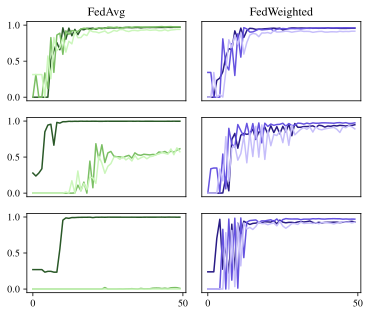

In [105]:
# server1=load_obj('noniid_20-20-20_baseline')
# server2=load_obj('noniid_20-20-20_weighted')

# server1=load_obj('noniid_30-15-15_baseline_b')
# server2=load_obj('noniid_30-15-15_weighted')

# server1=load_obj('noniid_40-10-10_baseline_b')
# server2=load_obj('noniid_40-10-10_weighted')


# colors1 = ['#336699', '#86bbd8', '#2f4858']
colors1 = ['#295827', '#7bbf64', '#cbf6bb']
colors2 = ['#291b85', '#6653e0', '#c6befa']
colors3 = ['#841a1a', '#e15454', '#fabdbd']
fig, axs = plt.subplots(3, 2, figsize=(6, 5))
fig.subplots_adjust(wspace=0.10, hspace=0.21)
for ax in axs.flatten():
  ax.set_xlim(-2, 51)
  ax.set_ylim(-0.05, 1.05)
  ax.set_xticks([])
  ax.set_yticks([])

for ax in axs[2]:
  ax.set_xticks([0, 50])
for ax in axs[:,0]:
  ax.set_yticks([0, 0.50, 1.0])

server1=load_obj('noniid_20-20-20_baseline')
server2=load_obj('noniid_20-20-20_weighted')
for t, c in zip(server1.test_acc_trackers, colors1):
    axs[0,0].plot(t, color=c)
axs[0,0].set_title('FedAvg')
for t, c in zip(server2.test_acc_trackers, colors2):
    axs[0,1].plot(t, color=c)
axs[0,1].set_title('FedWeighted')

server1=load_obj('noniid_30-15-15_baseline_b')
server2=load_obj('noniid_30-15-15_weighted')
for t, c in zip(server1.test_acc_trackers, colors1):
    axs[1,0].plot(t, color=c)
for t, c in zip(server2.test_acc_trackers, colors2):
    axs[1,1].plot(t, color=c)

server1=load_obj('noniid_40-10-10_baseline_b')
server2=load_obj('noniid_40-10-10_weighted')
for t, c in zip(server1.test_acc_trackers, colors1):
    axs[2,0].plot(t, color=c)
for t, c in zip(server2.test_acc_trackers, colors2):
    axs[2,1].plot(t, color=c)


plt.savefig('/Users/matthew/Desktop/Final/figs/mnist_acc.pdf')
plt.show()




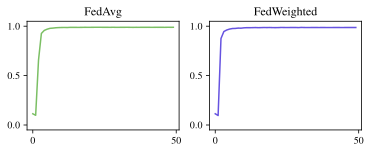

In [104]:
# colors1 = ['#336699', '#86bbd8', '#2f4858']
colors1 = ['#295827', '#7bbf64', '#cbf6bb']
colors2 = ['#291b85', '#6653e0', '#c6befa']
colors3 = ['#841a1a', '#e15454', '#fabdbd']
fig, axs = plt.subplots(1, 2, figsize=(6, 2))
# fig.subplots_adjust(wspace=0.10, hspace=0.21)
for ax in axs.flatten():
  ax.set_xlim(-2, 51)
  ax.set_ylim(-0.05, 1.05)
  ax.set_xticks([0, 50])
  ax.set_yticks([0, 0.50, 1.0])

server1=load_obj('iid_baseline')
server2=load_obj('iid_weighted')
for t, c in zip(server1.test_acc_trackers, colors1[1:]):
    axs[0].plot(t, color=c)
axs[0].set_title('FedAvg')
for t, c in zip(server2.test_acc_trackers, colors2[1:]):
    axs[1].plot(t, color=c)
axs[1].set_title('FedWeighted')

plt.savefig('/Users/matthew/Desktop/Final/figs/mnist_iid.pdf')
plt.show()




### IID Scenario

In [106]:
server = Server(
    net_CIFAR10,
    trainsets['CIFAR10'],
    testsets['CIFAR10'],
    num_clients=60,
)
server.train(rounds=50)
# save_obj(server, 'iid_baseline')
# server = Server(
#     net,
#     trainsets['FashionMNIST'],
#     testsets['FashionMNIST'],
#     num_clients=30,
# )
# server.train(rounds=50, weighted=True)
# save_obj(server, 'iid_weighted')

Round 1/50 (Training client 1/6)	:   0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x1152 and 800x120)

### Non-IID Scenario

Round 50/50 (Testing group 3/3)		: 100%|██████████| 50/50 [09:59<00:00, 11.99s/it]   


avg:
tensor([0.7310, 0.7851, 1.6997, 1.6122])


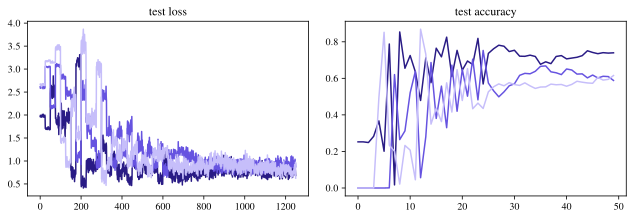

In [48]:
# server1 = Server(
#     net,
#     trainsets['FashionMNIST'],
#     testsets['FashionMNIST'],
#     num_clients=(20, 20, 20),
#     classes=((0, 1, 2, 3), (4, 5, 6), (7, 8, 9)),
# )
# server1.train(rounds=50, local_epochs=5, weighted=True)
# save_obj(server1, 'noniid_20-20-20_weighted')

server2 = Server(
    net,
    trainsets['FashionMNIST'],
    testsets['FashionMNIST'],
    num_clients=(20, 10, 10),
    classes=((0, 1, 2, 3), (4, 5, 6), (7, 8, 9)),
)
server2.train(rounds=50, local_epochs=5, weighted=True)
save_obj(server2, 'noniid_30-15-15_weighted')

# server3 = Server(
#     net,
#     trainsets['FashionMNIST'],
#     testsets['FashionMNIST'],
#     num_clients=(40, 10, 10),
#     classes=((0, 1, 2, 3), (4, 5, 6), (7, 8, 9)),
# )
# server3.train(rounds=50, local_epochs=5, weighted=True)
# save_obj(server3, 'noniid_40-10-10_weighted')